Plot saved as LakeCore1.pdf


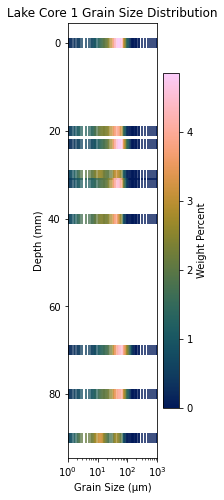

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmcrameri
import os
import pandas as pd

def extract_depths(file_name):
    depths_str = file_name.split('_')[-1].split('-')
    try:
        lower_depth = float(depths_str[0].replace('mm', '').strip())
        upper_depth = float(depths_str[1].replace('mm', '').strip())
        return lower_depth, upper_depth
    except (ValueError, IndexError) as e:
        raise ValueError(f"Error processing file name: {file_name}. Ensure it follows the format 'filename_lower-upper.csv'.") from e

# Function to read data from multiple CSV files
def read_multiple_data(directory):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            data = pd.read_csv(file_path)
            lower_depth, upper_depth = extract_depths(os.path.basename(file_path).split('.')[0])  # Extract depths from file name
            data['Lower Depth'] = lower_depth
            data['Upper Depth'] = upper_depth
            all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

def plot_combined_data(combined_data, output_pdf='LakeCore1.pdf'):
    fig, ax1 = plt.subplots(figsize=(2, 8))  # Adjust the width and height (in inches) as needed

    # Plot weight percent
    cmap = cmcrameri.cm.batlow  # Using the 'batlow' colormap from cmcrameri
    norm = mcolors.Normalize(vmin=0, vmax=combined_data['Histogram (%) q3'].max())
    
    # Filter out NaN values
    combined_data_filtered = combined_data.dropna(subset=['um', 'Lower Depth', 'Histogram (%) q3'])

    sc = ax1.scatter(combined_data_filtered['um'], combined_data_filtered['Lower Depth'], c=combined_data_filtered['Histogram (%) q3'], cmap=cmap, norm=norm, marker="|", s=100)
    cbar = plt.colorbar(sc, ax=ax1, label='Weight Percent')
    
    # Reverse the y-axis
    ax1.set_ylim(ax1.get_ylim()[::-1])

    # Set x-axis to log scale with range from 1 to 1000
    ax1.set_xscale('log')
    ax1.set_xlim(1, 1000)  # Set the x-axis limit from 1 to 1000

    # Set labels and titles
    ax1.set_xlabel('Grain Size (μm)')
    ax1.set_ylabel('Depth (mm)')
    ax1.set_title('Lake Core 1 Grain Size Distribution')
    
    # Save the figure as a PDF
    plt.savefig(output_pdf, bbox_inches='tight', dpi=300)
    print(f"Plot saved as {output_pdf}")
    
    plt.show()

# Directory containing CSV files
directory = 'FILENAMEHERE'
# Read and combine data from multiple CSV files
combined_data = read_multiple_data(directory)

# Plot combined data
plot_combined_data(combined_data)


Plot saved as LakeCore1_Wentworth.pdf


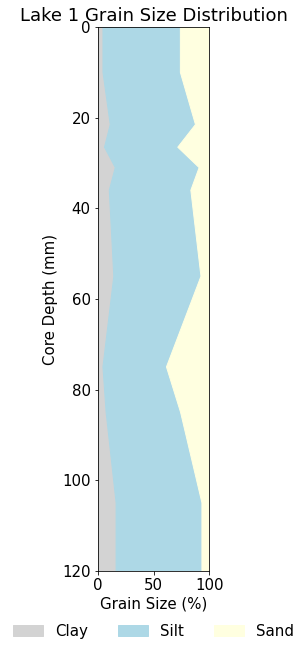

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

plt.rcParams.update({'font.size': 15})


def extract_depths(file_name):
    depths_str = file_name.split('_')[-1].split('-')
    try:
        lower_depth = float(depths_str[0].replace('mm', '').strip())
        upper_depth = float(depths_str[1].replace('mm', '').strip())
        center_depth = (lower_depth + upper_depth) / 2
        return lower_depth, upper_depth, center_depth
    except (ValueError, IndexError) as e:
        raise ValueError(f"Error processing file name: {file_name}. Ensure it follows the format 'filename_lower-upper.csv'.") from e

def read_multiple_data(directory):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            data = pd.read_csv(file_path)
            lower_depth, upper_depth, center_depth = extract_depths(os.path.basename(file_path).split('.')[0])
            data['Lower Depth'] = lower_depth
            data['Upper Depth'] = upper_depth
            data['Center Depth'] = center_depth
            all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

def plot_wentworth_scale(combined_data, output_pdf='LakeCore1_Wentworth.pdf'):
    wentworth_labels = ['Clay', 'Silt', 'Sand']
    wentworth_bins = [0, 4, 63, 2000]  # In microns
    
    fig, ax = plt.subplots(figsize= (2, 10))

    # Prepare data for filled plotting
    depths = combined_data['Center Depth'].unique()
    depths.sort()
    
    all_percent_data = []
    for depth in depths:
        depth_data = combined_data[combined_data['Center Depth'] == depth]
        percent_data = []
        
        for i in range(len(wentworth_bins) - 1):
            subset = depth_data[(depth_data['um'] >= wentworth_bins[i]) & (depth_data['um'] < wentworth_bins[i+1])]
            percent_data.append(subset['Histogram (%) q3'].sum())
        
        all_percent_data.append(percent_data)

    all_percent_data = np.array(all_percent_data)
    cumulative_data = np.cumsum(all_percent_data, axis=1)

    # Extend depth to fill to the top and bottom
    depths_filled = np.concatenate(([depths[0] - 100], depths, [depths[-1] + 100]))
    cumulative_data_filled = np.vstack((cumulative_data[0], cumulative_data, cumulative_data[-1]))

    # Plot filled areas for each grain size category
    colors = ['lightgray', 'lightblue', 'lightyellow']
    for i in range(len(wentworth_labels)):
        ax.fill_betweenx(depths_filled, cumulative_data_filled[:, i-1] if i > 0 else 0, cumulative_data_filled[:, i],
                          color=colors[i], label=wentworth_labels[i])
    ax.set_xlim(0,100)
    ax.set_ylim(0,120)
    ax.invert_yaxis()
    ax.set_ylabel('Core Depth (mm)')
    ax.set_xlabel('Grain Size (%)')
    ax.set_title('Lake 1 Grain Size Distribution')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=7, frameon=False)

    plt.savefig(output_pdf, bbox_inches='tight', dpi=300)
    print(f"Plot saved as {output_pdf}")
    plt.show()

# Directory containing CSV files
directory = 'FILENAMEHERE'
combined_data = read_multiple_data(directory)

# Plot using Wentworth scale
plot_wentworth_scale(combined_data)
